# CUT MIX AUGMENTATIONS
## -> Cut a Part of an Image & Mix to Another Image

In [31]:
# Import Depedencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import import_ipynb
import Utils

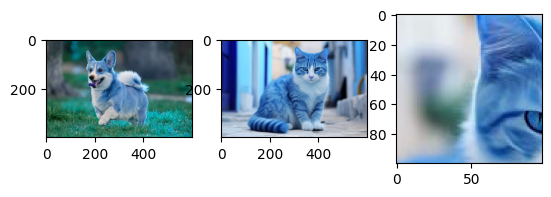

In [13]:
# Crop-To-Bounding-Box
dogImage = cv2.resize(cv2.imread("Images/dog.jpg"), (600, 400))
catImage = cv2.resize(cv2.imread("Images/cat.jpg"), (600, 400))
croppedImage = tf.image.crop_to_bounding_box(catImage, offset_height=50, offset_width=250, target_height=100, target_width=98)

plt.subplot(1, 3, 1)
plt.imshow(dogImage)

plt.subplot(1, 3, 2)
plt.imshow(catImage)

plt.subplot(1, 3, 3)
plt.imshow(croppedImage)

plt.show()

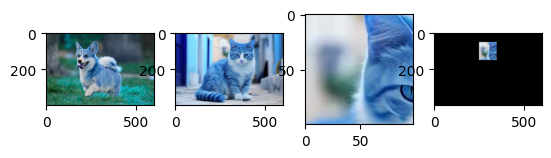

In [19]:
# Pad-To-Bounding-Box -> Pads cropped image with 0 pixels
dogImage = cv2.resize(cv2.imread("Images/dog.jpg"), (600, 400))
catImage = cv2.resize(cv2.imread("Images/cat.jpg"), (600, 400))
croppedImage = tf.image.crop_to_bounding_box(catImage, offset_height=50, offset_width=250, target_height=100, target_width=98)
padImage = tf.image.pad_to_bounding_box(croppedImage, offset_height=50, offset_width=250, target_height=400, target_width=600)
plt.subplot(1, 4, 1)
plt.imshow(dogImage)

plt.subplot(1, 4, 2)
plt.imshow(catImage)

plt.subplot(1, 4, 3)
plt.imshow(croppedImage)

plt.subplot(1, 4, 4)
plt.imshow(padImage)

plt.show()

# CUT-MIX

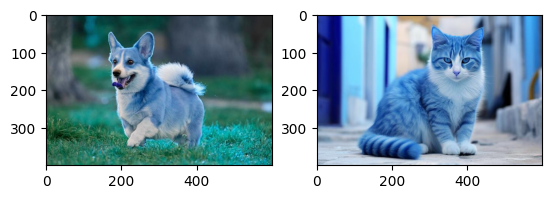

In [22]:
# Original Image
dogImage = cv2.resize(cv2.imread("Images/dog.jpg"), (600, 400))
catImage = cv2.resize(cv2.imread("Images/cat.jpg"), (600, 400))

plt.subplot(1, 2, 1)
plt.imshow(dogImage)

plt.subplot(1, 2, 2)
plt.imshow(catImage)

plt.show()

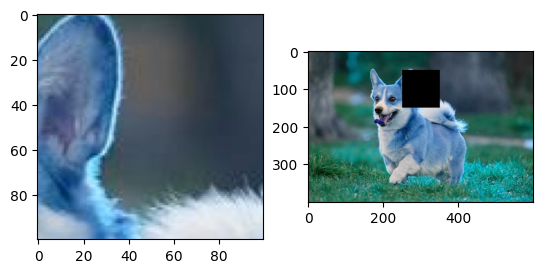

In [23]:
# Image to add on
croppedDog = tf.image.crop_to_bounding_box(dogImage, 50, 250, 100, 100)
paddedCroppedDog = tf.image.pad_to_bounding_box(croppedDog, 50, 250, 400, 600)
croppedDogRemaining = dogImage-paddedCroppedDog

plt.subplot(1, 2, 1)
plt.imshow(croppedDog)

plt.subplot(1, 2, 2)
plt.imshow(croppedDogRemaining)

plt.show()

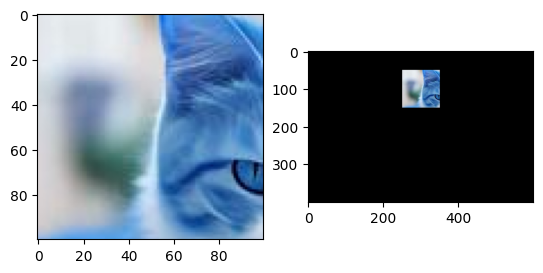

In [24]:
# Image to add
croppedCat = tf.image.crop_to_bounding_box(catImage, 50, 250, 100, 100)
croppedCatPadded = tf.image.pad_to_bounding_box(croppedCat, 50, 250, 400, 600)

plt.subplot(1, 2, 1)
plt.imshow(croppedCat)

plt.subplot(1, 2, 2)
plt.imshow(croppedCatPadded)

plt.show()

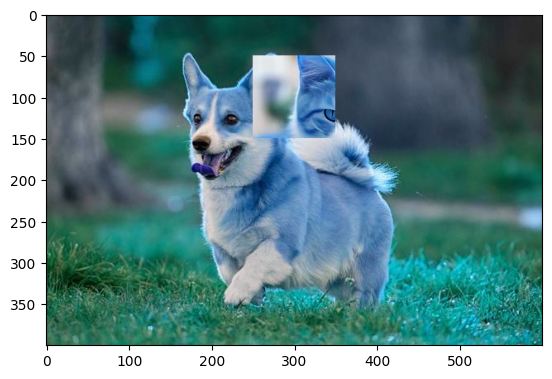

In [26]:
# Final Image
cutMixAugmentedImage = croppedDogRemaining + croppedCatPadded

plt.imshow(cutMixAugmentedImage)

In [43]:
# Beta Distribution
def sampleBeta(alpha, beta, shape):
    x = tf.random.gamma(shape, alpha)
    y = tf.random.gamma(shape, beta)

    lamda = x/(x+y)

    return lamda

# Get Bounding Boxes
def box(IMAGE_SIZE):
    rx = tf.cast(tf.random.uniform(shape=[], minval=0, maxval=IMAGE_SIZE), dtype=tf.int32)
    ry = tf.cast(tf.random.uniform(shape=[], minval=0, maxval=IMAGE_SIZE), dtype=tf.int32)

    lamda = sampleBeta(0.2, 0.2, [])

    rw = tf.cast(IMAGE_SIZE * tf.math.sqrt(1-lamda), dtype=tf.int32)
    rh = tf.cast(IMAGE_SIZE * tf.math.sqrt(1-lamda), dtype=tf.int32)

    rx = tf.clip_by_value(rx - rw//2, 0, IMAGE_SIZE)
    ry = tf.clip_by_value(ry - rh//2, 0, IMAGE_SIZE)

    xbr = tf.clip_by_value(rx + rw//2, 0, IMAGE_SIZE)
    ybr = tf.clip_by_value(ry + rh//2, 0, IMAGE_SIZE)

    rw = xbr - rx
    if rw==0:
        rw=1

    rh = ybr - ry
    if rh==0:
        rh=1

    return rx, ry, rw, rh

# Cut-Mix Function
def cutMix(trainDataset1, trainDataset2):
    (image1, label1), (image2, label2) = trainDataset1, trainDataset2

    IMAGE_SIZE = image1.shape[1]

    rx, ry, rw, rh = box(IMAGE_SIZE)

    crop1 = tf.image.crop_to_bounding_box(image1, ry, rx, rh, rw)
    pad1 = tf.image.pad_to_bounding_box(crop1, ry, rx, IMAGE_SIZE, IMAGE_SIZE)
    
    crop2 = tf.image.crop_to_bounding_box(image2, ry, rx, rh, rw)
    pad2 = tf.image.pad_to_bounding_box(crop2, ry, rx, IMAGE_SIZE, IMAGE_SIZE)

    cutMixAugmentedImage = image1-pad1+pad2

    lamda = tf.cast(1-(rw*rh)/(IMAGE_SIZE*IMAGE_SIZE), dtype=tf.float32)
    augmentedLabel = lamda*tf.cast(label1, dtype=tf.float32) + (1-lamda)*tf.cast(label2, dtype=tf.float32)

    return cutMixAugmentedImage, augmentedLabel

In [44]:
# Adding Cut-Mix Augnmentation To Our Model Pipeline
trainDataset1 = Utils.trainDataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
trainDataset2 = Utils.trainDataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)

mixedDataset = tf.data.Dataset.zip((trainDataset1, trainDataset2))

In [45]:
# Dataset Batching
BATCH_SIZE=32
BUFFER_SIZE = 8
trainDataset = mixedDataset.map(cutMix).shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valDataset = Utils.valDataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testDataset = Utils.testDataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

tf.Tensor(0.75444436, shape=(), dtype=float32)


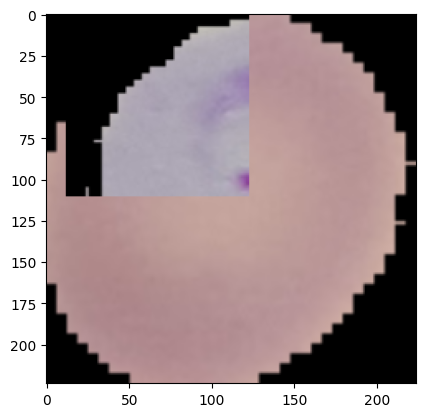

In [51]:
image, label = next(iter(trainDataset))
print(label[0])
plt.imshow(image[0])

In [52]:
# Training
Utils.model.fit(trainDataset, validation_data=valDataset, epochs=3, verbose=1)

Epoch 1/3


2025-01-25 10:34:02.534636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 62ms/step - auc: 0.6672 - binary_accuracy: 0.3487 - false_negatives: 2850.8115 - false_positives: 1032.6174 - loss: 0.6362 - precision: 0.8350 - recall: 0.6414 - true_negatives: 1717.6202 - true_positives: 5454.8984 - val_auc: 0.8569 - val_binary_accuracy: 0.7866 - val_false_negatives: 113.0000 - val_false_positives: 475.0000 - val_loss: 0.4970 - val_precision: 0.7298 - val_recall: 0.9191 - val_true_negatives: 884.0000 - val_true_positives: 1283.0000
Epoch 2/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - auc: 0.7560 - binary_accuracy: 0.4240 - false_negatives: 2495.5811 - false_positives: 800.8623 - loss: 0.5467 - precision: 0.8796 - recall: 0.7002 - true_negatives: 2025.8000 - true_positives: 5733.7046 - val_auc: 0.9584 - val_binary_accuracy: 0.8762 - val_false_negatives: 31.0000 - val_false_positives: 310.0000 - val_loss: 0.3755 - val_precision: 0.8145 - val_recall: 0.9777 - val_true_negatives: 1053.0000 - val_true_positives: 1361.0000
Epoch 3/3
689/6